# Convnets

- makes some assumptions...
- many layers: compositionality
- convolutions: locality + stationarity of images
- pooling: invariance of object class to translations

In [1]:
from plot_lib import plot_data, plot_model, set_default
set_default()

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

# function to count number of params
def get_n_params(model):
    return sum([p.nelement() for p in list(model.parameters())])

In [3]:
device = torch.device('cuda:0')

# MNIST

We will use Pytorch DataLoader utilities to download, shuffle, normalize data, and arrange it in batches.

In [6]:
input_size = 28*28
output_size = 10

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        root='data', train=True, download=True,
        transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])
    ),
    batch_size=64, shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        root='data', train=False, download=True, 
        transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])
    ),
    batch_size=1000, shuffle=True
)

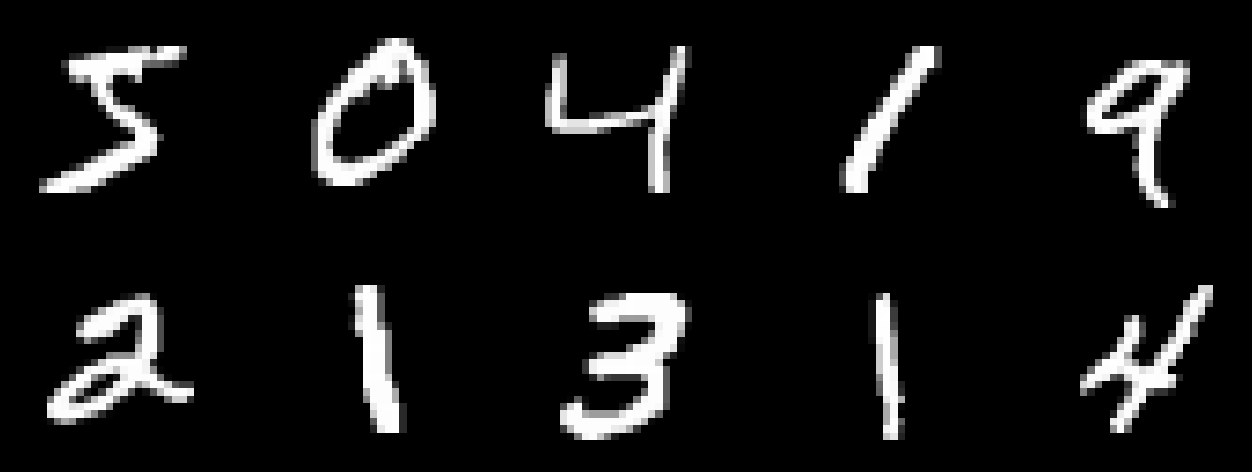

In [10]:
# show some images
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    image, _ = train_loader.dataset.__getitem__(i)
    plt.imshow(image.squeeze().numpy(), cmap='Greys_r')
    plt.axis('off')

# Create model classes

In [22]:
class FC2Layer(nn.Module):
    def __init__(self, input_size, n_hidden, output_size):
        super(FC2Layer, self).__init__()
        self.input_size = input_size
        self.network = nn.Sequential(
            nn.Linear(input_size, n_hidden), 
            nn.ReLU(),
            nn.Linear(n_hidden, n_hidden), 
            nn.ReLU(),
            nn.Linear(n_hidden, output_size),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, x):
        x = x.view(-1, self.input_size) # flatten before feeding in
        return self.network(x)

class CNN(nn.Module):
    def __init__(self, input_size, n_feature, output_size):
        super(CNN, self).__init__()
        self.n_feature = n_feature
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=n_feature, kernel_size=5)
        self.conv2 = nn.Conv2d(n_feature, n_feature, kernel_size=5)
        self.fc1 = nn.Linear(n_feature*4*4, 50)
        self.fc2 = nn.Linear(50, 10)
        
    def forward(self, x, verbose=False):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = x.view(-1, self.n_feature*4*4) # flattening step
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

# Train/test methods, GPU "device string"

In [19]:
accuracy_list = []

def train(epoch, model, perm=torch.arange(0, 784).long()):
    # put model in "train mode"
    model.train() 
    
    for batch_idx, (data, target) in enumerate(train_loader):
        
        # send to device
        data, target = data.to(device), target.to(device)
        
        # permute pixels (potentially mix em up)
        data = data.view(-1, 28*28)
        data = data[:, perm]
        data = data.view(-1, 1, 28, 28)
        
        # loss steps
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print(
                'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item()
                )
            )

def test(model, perm=torch.arange(0, 784).long()):
    # put model in "eval mode"
    model.eval()
    
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        
        # send to device
        data, target = data.to(device), target.to(device)
        
        # permute pixels?
        data = data.view(-1, 28*28)
        data = data[:, perm]
        data = data.view(-1, 1, 28, 28)
        
        # compute loss
        output = model(data)
        test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get index of max log-probability
        
        # note `torch.eq` -> element-wise equality. `view_as` just makes it the same shape
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()
        
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    accuracy_list.append(accuracy)
    
    print(
        '\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset), accuracy
        )
    )


# Train a small fully-connected network

In [20]:
n_hidden = 8 

model_fcnn = FC2Layer(input_size, n_hidden, output_size)
model_fcnn.to(device)

optimizer = optim.SGD(model_fcnn.parameters(), lr=0.01, momentum=0.5)
print(f'Number of parameters: {get_n_params(model_fcnn):d}')

for epoch in range(0, 1):
    train(epoch, model_fcnn)
    test(model_fcnn)

Number of parameters: 6442
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.311259
Train Epoch: 0 [6400/60000 (11%)]	Loss: 2.175314
Train Epoch: 0 [12800/60000 (21%)]	Loss: 1.811190
Train Epoch: 0 [19200/60000 (32%)]	Loss: 1.498780
Train Epoch: 0 [25600/60000 (43%)]	Loss: 1.585800
Train Epoch: 0 [32000/60000 (53%)]	Loss: 1.553447
Train Epoch: 0 [38400/60000 (64%)]	Loss: 1.149726
Train Epoch: 0 [44800/60000 (75%)]	Loss: 1.212644
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.988791
Train Epoch: 0 [57600/60000 (96%)]	Loss: 1.102176

Test set: Average loss: 0.8810, Accuracy: 6922/10000 (69%)



# Train a convnet with same number of params

In [23]:
n_features = 6

model_cnn = CNN(input_size, n_features, output_size)
model_cnn.to(device)
optimizer = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)
print(f'Number of parameters: {get_n_params(model_cnn)}')

for epoch in range(0, 1):
    train(epoch, model_cnn)
    test(model_cnn)

Number of parameters: 6422
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.288305
Train Epoch: 0 [6400/60000 (11%)]	Loss: 2.104883
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.625464
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.393890
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.281072
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.384431
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.412240
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.229112
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.245190
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.225472

Test set: Average loss: 0.2056, Accuracy: 9324/10000 (93%)



# What if we permute the pixels?

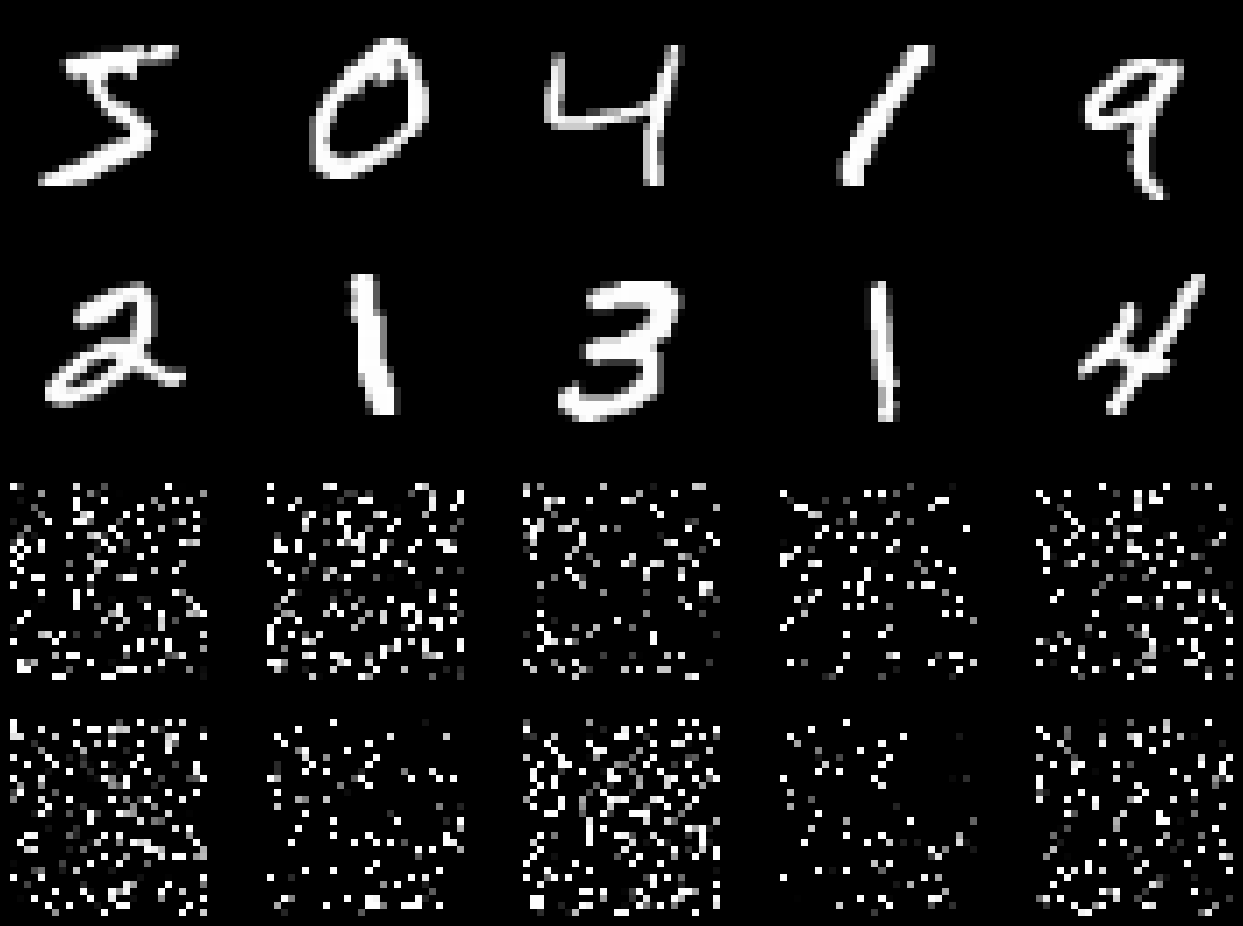

In [28]:
perm = torch.randperm(784)

plt.figure(figsize=(16, 12))
for i in range(10):
    image, _= train_loader.dataset.__getitem__(i)
    
    # permute pixels
    image_perm = image.view(-1, 28*28).clone()
    image_perm = image_perm[:, perm]
    image_perm = image_perm.view(-1, 1, 28, 28)
    
    plt.subplot(4, 5, i + 1)
    plt.imshow(image.squeeze().numpy(), cmap='Greys_r')
    plt.axis('off')
    
    plt.subplot(4, 5, i + 11)
    plt.imshow(image_perm.squeeze().numpy(), cmap='Greys_r')
    plt.axis('off')

## Convnet performance?

In [29]:
n_features = 6

model_cnn = CNN(input_size, n_features, output_size)
model_cnn.to(device)
optimizer = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_cnn)))

for epoch in range(0, 1):
    train(epoch, model_cnn, perm)
    test(model_cnn, perm)

Number of parameters: 6422
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.307259
Train Epoch: 0 [6400/60000 (11%)]	Loss: 2.240630
Train Epoch: 0 [12800/60000 (21%)]	Loss: 2.058513
Train Epoch: 0 [19200/60000 (32%)]	Loss: 1.851562
Train Epoch: 0 [25600/60000 (43%)]	Loss: 1.496893
Train Epoch: 0 [32000/60000 (53%)]	Loss: 1.072507
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.699568
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.819905
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.630875
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.738348

Test set: Average loss: 0.5901, Accuracy: 8192/10000 (82%)



## FCNN performance?

In [30]:
n_hidden = 8

model_fnn = FC2Layer(input_size, n_hidden, output_size)
model_fnn.to(device)
optimizer = optim.SGD(model_fnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_fnn)))

for epoch in range(0, 1):
    train(epoch, model_fnn, perm)
    test(model_fnn, perm)

Number of parameters: 6442
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.337977
Train Epoch: 0 [6400/60000 (11%)]	Loss: 1.874462
Train Epoch: 0 [12800/60000 (21%)]	Loss: 1.492421
Train Epoch: 0 [19200/60000 (32%)]	Loss: 1.406464
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.939495
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.673596
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.525397
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.706814
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.797987
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.419058

Test set: Average loss: 0.5173, Accuracy: 8491/10000 (85%)



# Comparison

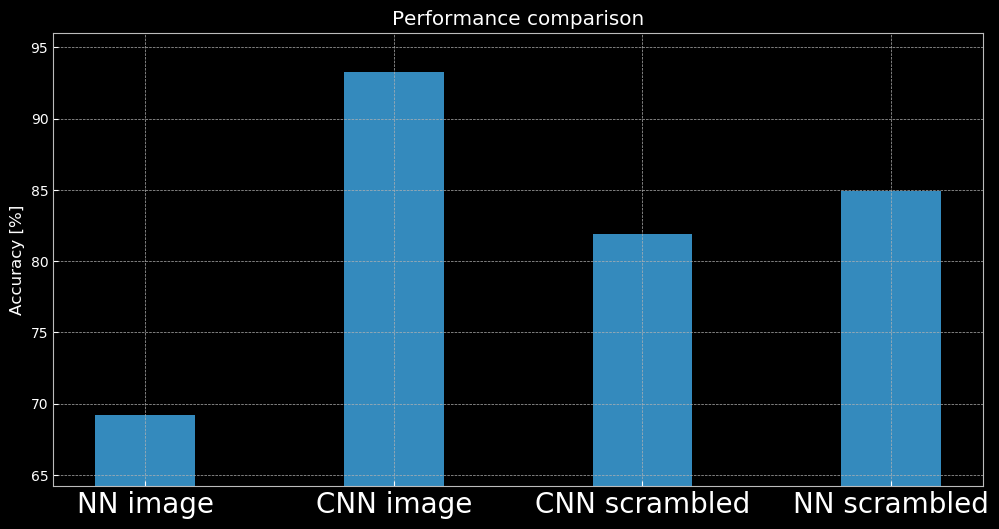

In [34]:
plt.figure(figsize=(12, 6))
plt.bar(('NN image', 'CNN image',
         'CNN scrambled', 'NN scrambled'),
        accuracy_list, width=0.4)
plt.ylim((min(accuracy_list)-5, 96))
plt.ylabel('Accuracy [%]')
for tick in plt.gca().xaxis.get_major_ticks():
    tick.label.set_fontsize(20)
plt.title('Performance comparison');

In [37]:
# checking model params
print(dir(model_cnn))

['__call__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_apply', '_backward_hooks', '_buffers', '_forward_hooks', '_forward_pre_hooks', '_get_name', '_load_from_state_dict', '_load_state_dict_pre_hooks', '_modules', '_named_members', '_parameters', '_register_load_state_dict_pre_hook', '_register_state_dict_hook', '_replicate_for_data_parallel', '_save_to_state_dict', '_slow_forward', '_state_dict_hooks', '_version', 'add_module', 'apply', 'buffers', 'children', 'conv1', 'conv2', 'cpu', 'cuda', 'double', 'dump_patches', 'eval', 'extra_repr', 'fc1', 'fc2', 'float', 'forward', 'half', 'load_state_dict', 'modules', 'n_feature', 'named_buffers', 'named_children',